In [1]:
import warnings

from arch import arch_model
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from xgboost import XGBRegressor, plot_importance, plot_tree

from preprocessor import DataProcessor
from model import TimeSeriesNeuroNetwork

warnings.filterwarnings(action="ignore")

/home/panda/anaconda3/envs/UM/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/panda/anaconda3/envs/UM/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


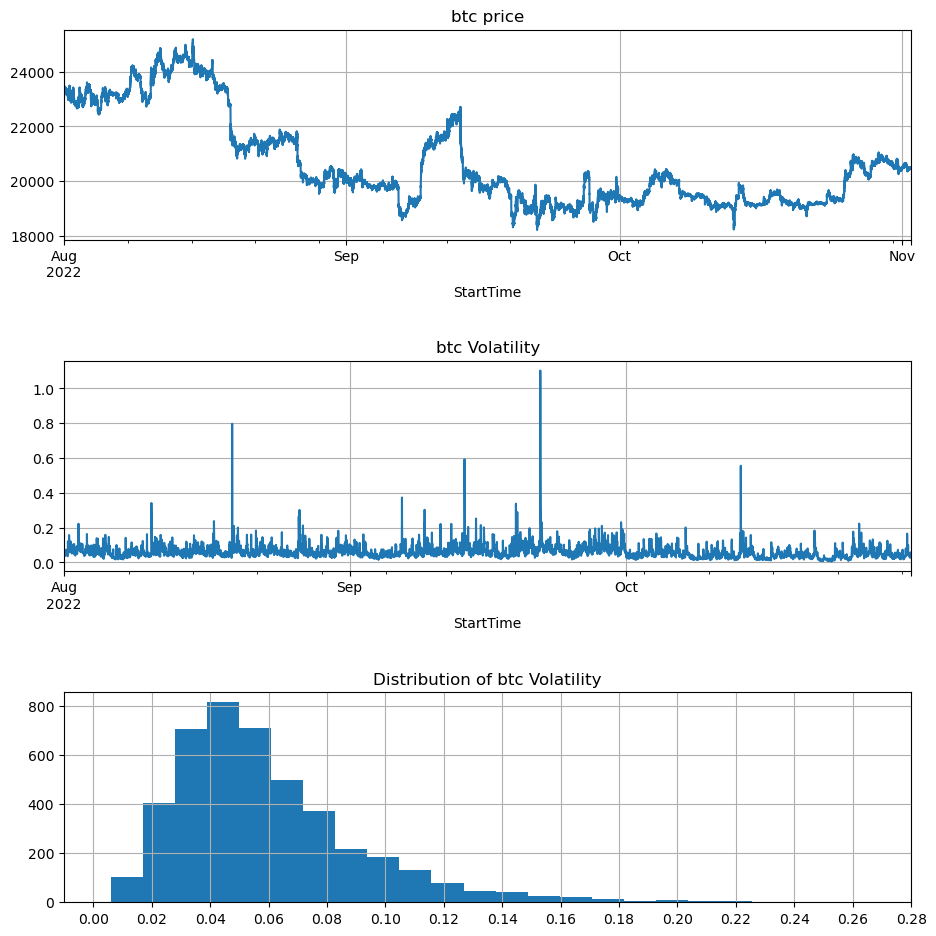

In [2]:
btc = DataProcessor("btc")
btc.plot()

## Baseline

{'MSE': 0.0009415453274452626, 'R^2': 0.05027177476655453}

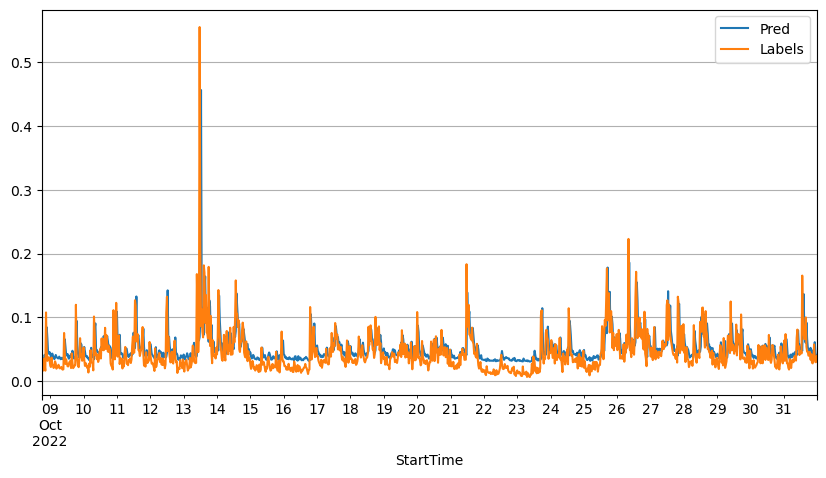

In [3]:
garch_features = btc._df_klines["Return"].dropna()
garch_model = arch_model(garch_features, vol='garch', p=1, o=0, q=1, rescale=False).fit(disp="off")
garch_labels = btc._labels[3300:]
garch_pred = (garch_model.forecast(reindex=False, start=garch_labels.index[0]).variance ** 0.5).resample("30T").mean()
btc.evaluate(garch_labels, garch_pred[garch_pred.index.isin(garch_labels.index)])

## Ridge with Raw Orderbook features

{'MSE': 0.0008920980269316081, 'R^2': 0.10359254934162221}

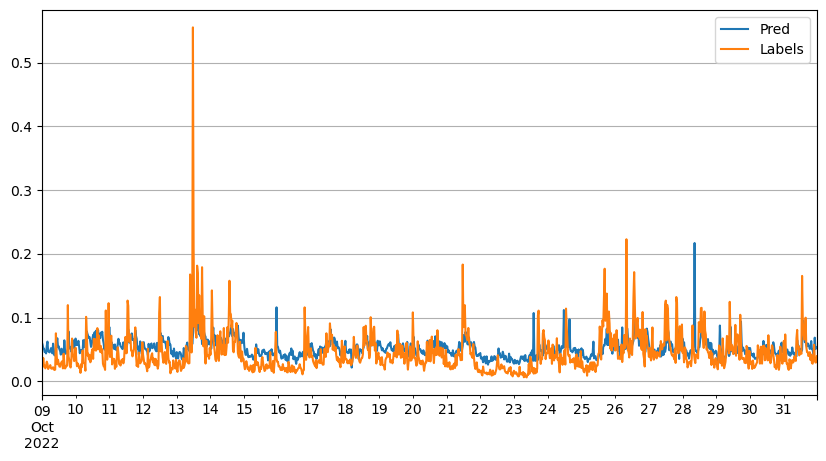

In [4]:
ridge = Ridge(alpha=5000)
train_X, train_y, val_X, val_y, test_X, test_y = btc.split_train_val_test(0.75, 0, 0.25)
ridge.fit(train_X, train_y)
pred_y = ridge.predict(test_X)
btc.evaluate(test_y, pred_y)

## Ridge with PCA and more features

In [2]:
def build_features(df_ob: pd.DataFrame) -> pd.DataFrame:
    df_features = pd.DataFrame(index=df_ob.index)
    ask_vol = sum(df_ob[f"Av{i}"] for i in range(1, 6))
    bid_vol = sum(df_ob[f"Bv{i}"] for i in range(1, 6))
    mid_price = (df_ob["Ap1"] + df_ob["Bp1"]) / 2
    df_features["Spread"] = (df_ob["Ap1"] - df_ob["Bp1"]) / mid_price
    df_features["WSpread"] = sum(df_ob[f"Ap{i}"] * df_ob[f"Av{i}"] / ask_vol - df_ob[f"Bp{i}"] * df_ob[f"Bv{i}"] / bid_vol for i in range(1, 6)) / mid_price
    df_features["VolumeSpread"] = (df_ob["Av1"] - df_ob["Bv1"]) / (df_ob["Av1"] + df_ob["Bv1"])
    df_features["WMP"] = (df_ob["Ap1"] * df_ob["Bv1"] +  df_ob["Bp1"] * df_ob["Av1"]) * 2 / (df_ob["Ap1"] + df_ob["Bp1"]) / (df_ob["Av1"] + df_ob["Bv1"])
    df_features["MP"] = mid_price
    return df_features

def build_all_features(df_ob: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_ob, build_features(df_ob)], axis=1)


btc_features = DataProcessor("BTC", build_features)
btc_all = DataProcessor("BTC", build_all_features)

{'MSE': 0.0007807694719238425, 'R^2': 0.21545889493061754}

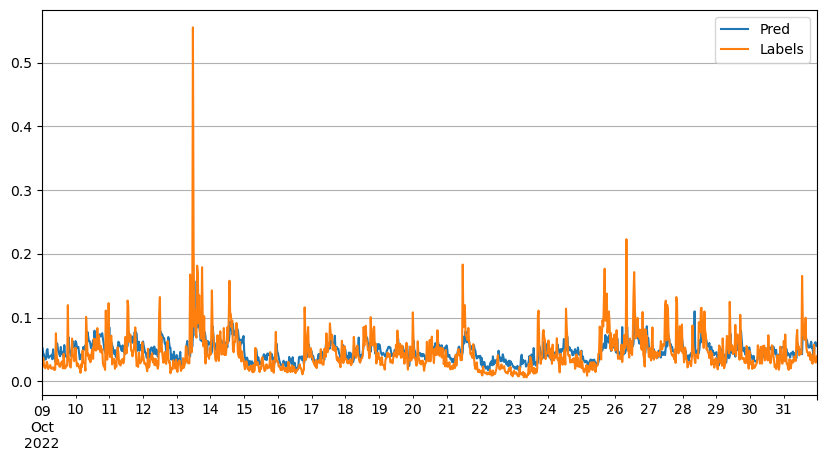

In [9]:
train_X, train_y, val_X, val_y, test_X, test_y = btc_all.split_train_val_test(0.75, 0, 0.25)
pipeline_pca = Pipeline([("scaler1", StandardScaler()), ("kpca", KernelPCA(random_state=1, n_components=5)), ("ridge", Ridge())])
pipeline_pca.fit(train_X, train_y)
pred_y = pipeline_pca.predict(test_X)
btc_all.evaluate(test_y, pred_y)

## XGBoost with new features

{'MSE': 0.0009315966196285843, 'R^2': 0.0639031523076744}

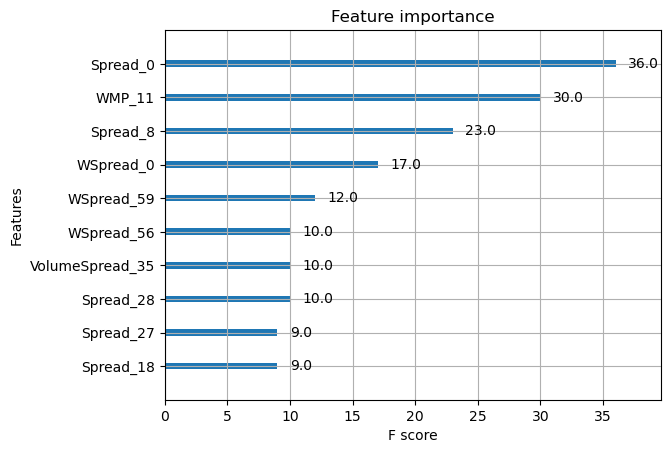

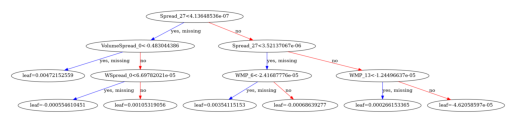

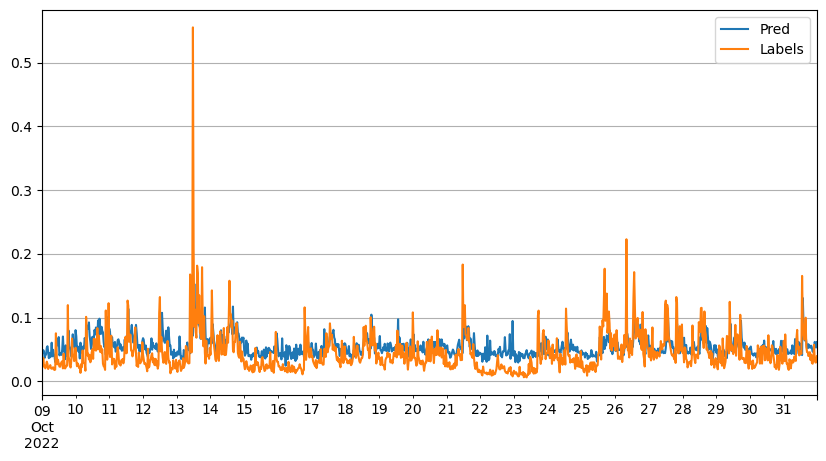

In [11]:
xgb = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1, learning_rate=0.1)
train_X, train_y, val_X, val_y, test_X, test_y = btc_features.split_train_val_test(0.75, 0, 0.25)
xgb.fit(train_X, train_y)
pred_y = xgb.predict(test_X)
plot_importance(xgb, max_num_features=10)
plot_tree(xgb, num_trees=xgb.get_booster().best_iteration)
btc_features.evaluate(test_y, pred_y)

## LSTM

{'MSE': 0.0006905927264351648, 'R^2': 0.14850572404239437}

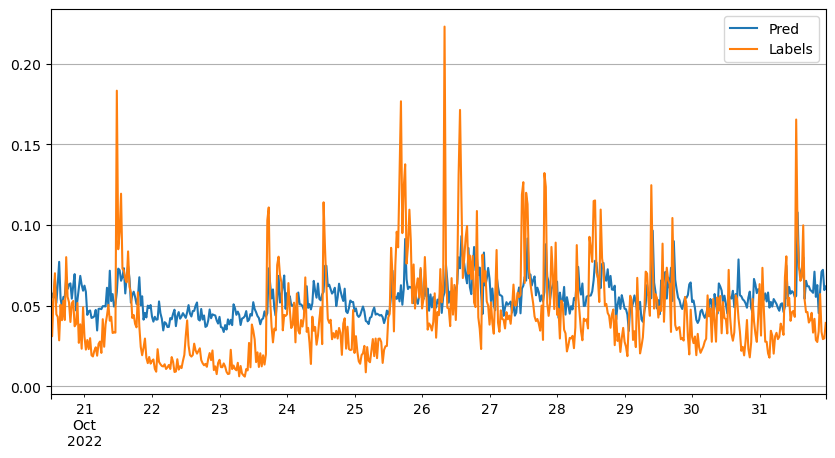

In [8]:
model_params = {
    "input_size": 5,
    "hidden_size": 32,
    "num_layers": 2,
    "model_type": "lstm",
    "batch_size": 128,
    "batch_normalize": False
}
lstm = TimeSeriesNeuroNetwork(**model_params)
optimizer = Adam(lstm.parameters(), lr=5e-5, weight_decay=1e-6)
train_X, train_y, val_X, val_y, test_X, test_y = btc_features.split_train_val_test(0.75, 0.125, 0.125)
scaler = StandardScaler().fit(train_X)
lstm.fit(
    scaler.transform(train_X),
    train_y,
    val_X=scaler.transform(val_X),
    val_y=val_y,
    optimizer=optimizer,
    epochs=50,
    verbose=False,
)
pred_y = lstm.predict(scaler.transform(test_X))
btc_features.evaluate(test_y, pred_y)

## LSTM + Dropout + PCA

{'MSE': 0.0013326393522309593, 'R^2': -0.6431316706707975}

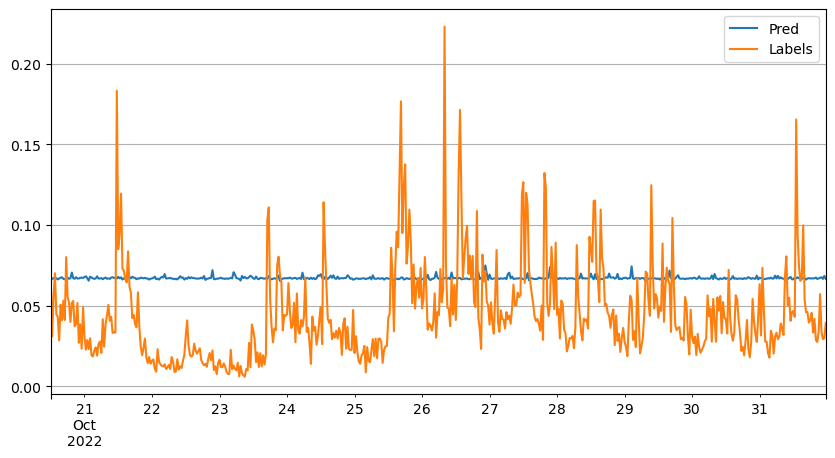

In [9]:
model_params = {
    "input_size": 5,
    "hidden_size": 64,
    "num_layers": 3,
    "model_type": "lstm",
    "batch_size": 128,
    "batch_normalize": False,
    "dropout": 0.25,
}
lstm = TimeSeriesNeuroNetwork(**model_params)
pipeline_lstm = Pipeline(
    [
        ("scaler1", StandardScaler()),
        ("kpca", KernelPCA(n_components=300)),
        ("scaler2", StandardScaler()),
        ("lstm", lstm),
    ]
)
optimizer = Adam(lstm.parameters(), lr=5e-5, weight_decay=1e-6)
train_X, train_y, val_X, val_y, test_X, test_y = btc_all.split_train_val_test(
    0.75, 0.125, 0.125, shuffle=False
)
pipeline_lstm.fit(
    train_X,
    train_y,
    lstm__val_X=val_X,
    lstm__val_y=val_y,
    lstm__optimizer=optimizer,
    lstm__epochs=20,
    lstm__verbose=False
)
pred_y = pipeline_lstm.predict(test_X)
btc_all.evaluate(test_y, pred_y)

## GRU with batch normalization

{'MSE': 0.0015957999273083483, 'R^2': -0.9676061615806664}

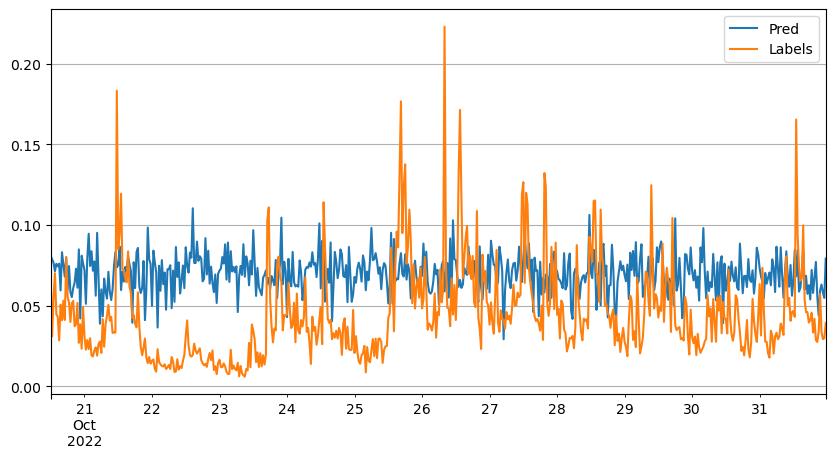

In [10]:
model_params = {
    "input_size": 25,
    "hidden_size": 32,
    "num_layers": 2,
    "model_type": "gru",
    "batch_size": 64,
    "batch_normalize": True,
}
gru = TimeSeriesNeuroNetwork(**model_params)
optimizer = Adam(gru.parameters(), lr=5e-5, weight_decay=1e-6)
train_X, train_y, val_X, val_y, test_X, test_y = btc_all.split_train_val_test(
    0.75, 0.125, 0.125, shuffle=False
)
gru.fit(
    train_X,
    train_y,
    val_X=val_X,
    val_y=val_y,
    optimizer=optimizer,
    epochs=20,
    verbose=False
)
pred_y = gru.predict(test_X)
btc_all.evaluate(test_y, pred_y)